In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [10]:
import numpy as np 
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    device = 'cuda'
if torch.backends.mps.is_available():
    device = 'mps'

In [13]:
class FVSBN(nn.Module):
    def __init__(self, n_dim = 784): 
        super(FVSBN, self).__init__()
        self.n_dim = n_dim
        self.linear_layers = nn.ModuleList(
            nn.Linear(in_features = max(1,i), out_features = 1) for i in range(n_dim)
        )

    
    def forward(self, input): 
        original_shape = input.shape
        input = input.view(original_shape[0], -1)

        output = [self.linear_layers[0](torch.zeros(original_shape[0], 1, device = device))]

        for i in range(1, self.n_dim): 
            output.append(self.linear_layers[i](input[:,:i]))
        output = torch.stack(output, axis = 1)
        return output
    
    # def sample(self,)




In [20]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root = './data', train = True, download = True , transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)



device = torch.device(device)
print(device)


model = FVSBN(784)
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0.0
    for images, _ in train_loader:
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        images = images.to(device)
        output = torch.squeeze(model(images))
        output.to(device)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate the average loss for the epoch
    epoch_loss = total_loss/ images.shape[0]
    

    # Print the loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

mps
Epoch [1/50], Loss: 4.4291
Epoch [2/50], Loss: 2.9697


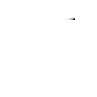

In [19]:
new_image = model.sample(0.3,784)
image_2d = new_image.view(28,28)
img = image_2d.cpu().detach().numpy()
plt.figure(figsize=(1, 1))
plt.imshow(img, cmap = 'gray')
plt.axis('off')  # Turn off axis
plt.show()